In [1]:
#load and slit
import pandas as pd

# Load your raw fire+no-fire merged file
df = pd.read_csv("fire_vs_no_fire_locations.csv")

# Split by label
df_fire = df[df['fire_occurred'] == 1]
df_no_fire = df[df['fire_occurred'] == 0]

# Sample smaller balanced subset (adjust numbers if needed)
df_fire_sample = df_fire.sample(n=500, random_state=42)
df_no_fire_sample = df_no_fire.sample(n=500, random_state=42)

# Combine and shuffle
df_small = pd.concat([df_fire_sample, df_no_fire_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# Save to use for enrichment
df_small.to_csv("fire_vs_no_fire_samplee.csv", index=False)

print(f" Reduced sample dataset created. Shape: {df_small.shape}")


 Reduced sample dataset created. Shape: (1000, 4)


In [2]:
import pandas as pd
import requests
from tqdm import tqdm
import time
import math
from datetime import datetime

# Load dataset
df = pd.read_csv("fire_vs_no_fire_samplee.csv")

# Convert date column and filter invalid dates
df['acq_date'] = pd.to_datetime(df['acq_date'], errors='coerce')
df = df.dropna(subset=['acq_date'])

# Remove rows with future dates (NASA POWER does not support them)
today = pd.to_datetime(datetime.utcnow().date())
df = df[df['acq_date'] < today].copy()

# Initialize new columns for enriched features
df['temperature'] = None
df['humidity'] = None
df['wind_speed'] = None
df['precipitation'] = None
df['elevation'] = None
df['vpd'] = None

# Function to fetch weather data from NASA POWER
def fetch_weather(lat, lon, date):
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "T2M,RH2M,WS2M,PRECTOTCORR",
        "community": "AG",
        "longitude": lon,
        "latitude": lat,
        "start": date.strftime('%Y%m%d'),
        "end": date.strftime('%Y%m%d'),
        "format": "JSON"
    }

    try:
        r = requests.get(url, params=params, timeout=10)
        r.raise_for_status()
        data = r.json()
        props = data["properties"]["parameter"]
        key = date.strftime('%Y%m%d')
        return {
            "temperature": props["T2M"].get(key),
            "humidity": props["RH2M"].get(key),
            "wind_speed": props["WS2M"].get(key),
            "precipitation": props["PRECTOTCORR"].get(key)
        }
    except Exception as e:
        print(f"Weather error for {lat},{lon},{date}: {e}")
        return None

# Function to fetch elevation from OpenTopoData
def fetch_elevation(lat, lon):
    url = f"https://api.opentopodata.org/v1/srtm90m?locations={lat},{lon}"
    try:
        r = requests.get(url)
        r.raise_for_status()
        return r.json()["results"][0]["elevation"]
    except Exception as e:
        print(f"Elevation error for {lat},{lon}: {e}")
        return None

# Function to compute VPD (Vapor Pressure Deficit)
def compute_vpd(temp, rh):
    try:
        es = 0.6108 * math.exp((17.27 * temp) / (temp + 237.3))  # Saturation vapor pressure
        ea = es * (rh / 100.0)                                   # Actual vapor pressure
        return round(es - ea, 3)
    except:
        return None

# Enrichment loop
for i, row in tqdm(df.iterrows(), total=len(df)):
    lat, lon, date = row['latitude'], row['longitude'], row['acq_date']

    weather = fetch_weather(lat, lon, date)
    if weather:
        df.at[i, 'temperature'] = weather['temperature']
        df.at[i, 'humidity'] = weather['humidity']
        df.at[i, 'wind_speed'] = weather['wind_speed']
        df.at[i, 'precipitation'] = weather['precipitation']
        df.at[i, 'vpd'] = compute_vpd(weather['temperature'], weather['humidity'])

    elevation = fetch_elevation(lat, lon)
    if elevation is not None:
        df.at[i, 'elevation'] = elevation

    time.sleep(0.6)  # Respect API rate limits

# Save enriched dataset
df.to_csv("fire_dataset_enriched.csv", index=False)
print("Enrichment complete. Saved as fire_dataset_enriched.csv.")


C:\Users\dipak\AppData\Local\Temp\ipykernel_14852\1600827521.py:16: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  today = pd.to_datetime(datetime.utcnow().date())
  4%|███▌                                                                          | 45/1000 [03:15<1:06:40,  4.19s/it]

Weather error for 28.46765,82.30481,2024-06-10 00:00:00: HTTPSConnectionPool(host='power.larc.nasa.gov', port=443): Read timed out. (read timeout=10)


 10%|███████▍                                                                      | 95/1000 [07:07<1:08:49,  4.56s/it]

Weather error for 28.7819,80.41485,2016-04-14 00:00:00: 502 Server Error: Bad Gateway for url: https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M%2CRH2M%2CWS2M%2CPRECTOTCORR&community=AG&longitude=80.41485&latitude=28.7819&start=20160414&end=20160414&format=JSON


 20%|███████████████▏                                                             | 197/1000 [15:31<1:05:20,  4.88s/it]

Weather error for 29.40838,80.45134,2016-04-12 00:00:00: 502 Server Error: Bad Gateway for url: https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M%2CRH2M%2CWS2M%2CPRECTOTCORR&community=AG&longitude=80.45134&latitude=29.40838&start=20160412&end=20160412&format=JSON


 35%|███████████████████████████▉                                                   | 353/1000 [27:45<51:03,  4.73s/it]

Weather error for 29.0521,80.5388,2023-04-18 00:00:00: 502 Server Error: Bad Gateway for url: https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M%2CRH2M%2CWS2M%2CPRECTOTCORR&community=AG&longitude=80.5388&latitude=29.0521&start=20230418&end=20230418&format=JSON


 38%|██████████████████████████████▏                                                | 382/1000 [29:53<42:50,  4.16s/it]

Weather error for 28.44719947205094,86.93378529396149,2016-04-27 00:00:00: 502 Server Error: Bad Gateway for url: https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M%2CRH2M%2CWS2M%2CPRECTOTCORR&community=AG&longitude=86.93378529396149&latitude=28.44719947205094&start=20160427&end=20160427&format=JSON


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [57:22<18:16,  4.30s/it]

Weather error for 28.09433660371082,88.97019485059653,2023-05-08 00:00:00: HTTPSConnectionPool(host='power.larc.nasa.gov', port=443): Read timed out. (read timeout=10)


 80%|█████████████████████████████████████████████████████████████▉               | 804/1000 [1:03:25<15:18,  4.69s/it]

Weather error for 26.84999,86.24672,2016-03-02 00:00:00: HTTPSConnectionPool(host='power.larc.nasa.gov', port=443): Read timed out. (read timeout=10)


 98%|███████████████████████████████████████████████████████████████████████████▎ | 978/1000 [1:17:12<01:48,  4.95s/it]

Weather error for 27.22763,86.18475,2024-04-17 00:00:00: HTTPSConnectionPool(host='power.larc.nasa.gov', port=443): Read timed out. (read timeout=10)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:19:13<00:00,  4.75s/it]

Enrichment complete. Saved as fire_dataset_enriched.csv.


### Verify Data Integrity

In [1]:
import pandas as pd

df = pd.read_csv("fire_dataset_enriched.csv")
print("Total rows:", len(df))
print("\nMissing values per column:")
print(df.isnull().sum())


Total rows: 1000

Missing values per column:
latitude         0
longitude        0
acq_date         0
fire_occurred    0
temperature      8
humidity         8
wind_speed       8
precipitation    8
elevation        0
vpd              8
dtype: int64


In [2]:
# Drop rows with any missing values
df_cleaned = df.dropna()
df_cleaned.to_csv("fire_dataset_cleaned.csv", index=False)
print("Cleaned dataset saved with", len(df_cleaned), "rows.")
dropped = len(df) - len(df_cleaned)
print(f"Dropped {dropped} rows due to missing data.")


Cleaned dataset saved with 992 rows.
Dropped 8 rows due to missing data.


In [3]:
print(df_cleaned['fire_occurred'].value_counts())


fire_occurred
0    498
1    494
Name: count, dtype: int64


### ML Pipeline for Fire Prediction

In [7]:
!pip install catboost xgboost lightgbm scikit-learn

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 882.6 kB/s eta 0:00:02
   -------------- ------------------------- 0.5/1.5 MB 882.6 kB/s eta 0:00:02
   --------------------- ------------------ 0.8/1.5 MB 859.5 kB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.5 MB 882.6 kB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.5 MB 882.6 kB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.5 MB 882.6 kB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.5 MB 882.6 kB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.5 MB 621.2 kB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.5 MB 621.2 kB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 585.3 kB/s eta 0:00:00


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load sampled or cleaned data
df = pd.read_csv("fire_dataset_enriched.csv")  

# Drop any remaining NaNs
df.dropna(inplace=True)

# Features and target
features = ['latitude', 'longitude', 'temperature', 'humidity', 'wind_speed',
            'precipitation', 'elevation', 'vpd']
X = df[features]
y = df['fire_occurred']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale (for logistic regression, optional for tree models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Train Multiple Models

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(verbose=0),
    "LightGBM": LGBMClassifier()
}

results = {}

for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = {'Accuracy': round(acc*100, 2), 'F1-Score': round(f1, 3)}

print("\n Model Performance:")
for name, metrics in results.items():
    print(f"{name}: Accuracy = {metrics['Accuracy']}%, F1 = {metrics['F1-Score']}")



🔧 Training Logistic Regression...

🔧 Training Random Forest...

🔧 Training XGBoost...

🔧 Training CatBoost...


C:\Users\dipak\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:41:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training LightGBM...
[LightGBM] [Info] Number of positive: 394, number of negative: 399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 793, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496847 -> initscore=-0.012611
[LightGBM] [Info] Start training from score -0.012611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

C:\Users\dipak\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\dipak\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\dipak\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dipak\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\dipak\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

In [10]:
import joblib

best_model = CatBoostClassifier(verbose=0)
best_model.fit(X, y) 
joblib.dump(best_model, "catboost_final_model.pkl")
print("Final model saved as catboost_final_model.pkl")


✅ Final model saved as catboost_final_model.pkl


Test dataset saved as fire_test_dataset.csv

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       100
           1       0.93      1.00      0.96        99

    accuracy                           0.96       199
   macro avg       0.96      0.96      0.96       199
weighted avg       0.96      0.96      0.96       199



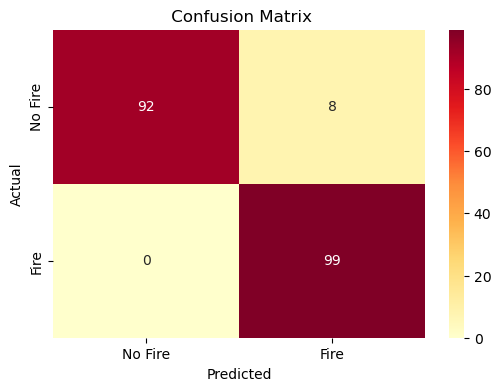

In [12]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load enriched dataset
df = pd.read_csv("fire_dataset_enriched.csv")

# Step 2: Drop rows with any missing values (cleaning)
df = df.dropna()

# Step 3: Define features and target
features = [
    "latitude", "longitude", "temperature", "humidity",
    "wind_speed", "precipitation", "elevation", "vpd"
]
target = "fire_occurred"

X = df[features]
y = df[target]

# Step 4: Split into train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 5: Save test set
test_df = X_test.copy()
test_df["fire_occurred"] = y_test
test_df.to_csv("fire_test_dataset.csv", index=False)
print("Test dataset saved as fire_test_dataset.csv")

# Step 6: Load trained model
model = joblib.load("model/catboost_final_model.pkl")

# Step 7: Predict on test data
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Step 8: Show classification metrics
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Step 9: Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(' Confusion Matrix')
plt.show()


In [13]:
# Select a small test set (say 5 random rows)
sample_test = df.sample(5, random_state=42)

# Show them
sample_test[['latitude', 'longitude', 'temperature', 'humidity', 'wind_speed', 'precipitation', 'elevation', 'vpd', 'fire_occurred']]

# Define features used in model
features = ['latitude', 'longitude', 'temperature', 'humidity', 'wind_speed', 
            'precipitation', 'elevation', 'vpd']

# Predict fire risk
X = sample_test[features]
y_true = sample_test['fire_occurred']
y_pred = model.predict(X)

# Show predictions alongside actual
sample_test['predicted_fire'] = y_pred
sample_test[['latitude', 'longitude', 'fire_occurred', 'predicted_fire']]

from sklearn.metrics import classification_report

print(" Classification Report for Sample Test:")
print(classification_report(y_true, y_pred, target_names=["No Fire", "Fire"]))

for idx, row in sample_test.iterrows():
    true_label = " Fire" if row['fire_occurred'] == 1 else " No Fire"
    predicted = " Fire" if row['predicted_fire'] == 1 else " No Fire"
    print(f"Lat: {row['latitude']:.2f}, Lon: {row['longitude']:.2f} → True: {true_label}, Predicted: {predicted}")


🔥 Classification Report for Sample Test:
              precision    recall  f1-score   support

     No Fire       1.00      1.00      1.00         3
        Fire       1.00      1.00      1.00         2

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

Lat: 26.42, Lon: 81.34 → True: 🌿 No Fire, Predicted: 🌿 No Fire
Lat: 29.07, Lon: 80.26 → True: 🔥 Fire, Predicted: 🔥 Fire
Lat: 30.35, Lon: 82.62 → True: 🌿 No Fire, Predicted: 🌿 No Fire
Lat: 27.10, Lon: 81.84 → True: 🌿 No Fire, Predicted: 🌿 No Fire
Lat: 27.44, Lon: 84.24 → True: 🔥 Fire, Predicted: 🔥 Fire


### Backend API with FastAP

In [14]:
!pip install fastapi uvicorn joblib pandas requests

  Using cached fastapi-0.115.13-py3-none-any.whl.metadata (27 kB)
  Using cached uvicorn-0.34.3-py3-none-any.whl.metadata (6.5 kB)
  Using cached starlette-0.46.2-py3-none-any.whl.metadata (6.2 kB)
Using cached fastapi-0.115.13-py3-none-any.whl (95 kB)
Using cached uvicorn-0.34.3-py3-none-any.whl (62 kB)
Using cached starlette-0.46.2-py3-none-any.whl (72 kB)
